# Gaussian Process Regression

In this notebook we construct a Gaussian process from scratch, using only numpy and scipy packages. This is for educational purposes, and although it has a modest performance it is not build for speed. Hope it is useful. 

In [ ]:
# Authors:
# A. del Rio Chanona  - Imperial College
# E. Bradford         - NTNU: Norwegian University of Science and Technology
# P.Petsagkourakis    - UCL: University College London
# E.I. Sanchez Medina - Max Planck Institute for Dynamics of Complex Technical Systems

# To cite please use the publications [1][2] at the bottom of the notebook.

# Optimisation and Machine Learning for Process Systems Engineering: 
# https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/about-us/

# Other codes: https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/codes/

import numpy as np
import time
import numpy.random as rnd
from scipy.spatial.distance import cdist
#!pip install sobol_seq #(needed in collab) 
import sobol_seq
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Review on Multivariate Gaussian distribution

Undersdtanding multivariate Gaussian distributions is important to fully grasp Gaussian processes, for this reason we strart with a small review. This should be skipped by people already familiar with multivariate Gaussians.



### Single variate Gaussian

A random variable follows a univariate Gaussian distribution if its probability density function is given 
$$p(x)=\frac{1}{(2\pi\sigma^2)^{1/2}}\text{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

where $x\in\mathbb{R}$ is the result of a single test. A Gaussian distribution is defined by its mean $\mu$  (expectation), and its variance $\sigma^2$. This is generally written as $x \sim \mathcal{N}(\mu,\sigma^2)$.

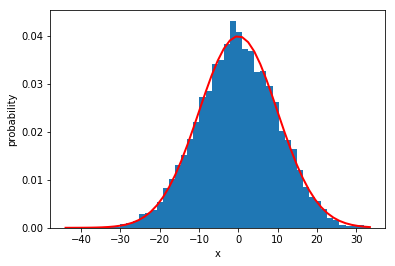

In [ ]:
mu, sigma = 0, 10 # mean and standard deviation
s         = np.random.normal(mu, sigma, 10000) # draw 3000 samples

# ----------- plotting ----------- #
count, bins, ignored = plt.hist(s, 50, density=True)
plt.plot(bins, 
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.ylabel('probability')
plt.xlabel('x')
plt.show()




### Multivariate Gaussian

Let us generalize this definition into higher dimensions. For a given random $D$-dimensional vector ${\bf x}=[x_1,...,x_D]^T$ with mean ${\bf \mu}=[\mu_1,...,\mu_D]^T$ its covariance matrix ${\bf \Sigma}=\text{cov}({\bf x})$ is defined as a $D \times D$ matrix of which the entry at the $i^{th}$ row and $j^{th}$ column is calculated by

$$\text{cov}(x_i,x_j)=\text{E}[ x_ix_j]-\text{E}[ x_i]\text{E}[ x_j]$$
hence
$${\bf \Sigma} = \begin{bmatrix}
    \text{cov}(x_1,x_1), & ...  & \text{cov}(x_1,x_D)  \\
    \text{cov}(x_2,x_1), & ...  &\text{cov}(x_2,x_D) \\
    \vdots & \ddots  & \vdots  \\
    \text{cov}(x_D,x_1),& ... & \text{cov}(x_D,x_D) 
\end{bmatrix}\qquad$$

The covariance $\text{cov}(x_i,x_j)$ is a measure of the correlation between the component $x_i$ and the component $x_j$. Thus, if these components are independent, $\text{E}[ x_ix_j]=\text{E}[ x_i]\text{E}[ x_j]$ and the covariance coefficient $(i,j)$ becomes 0.


A covariance matrix must be symmetric positive semidefinite. This necessitates the diagonal elements to be non-negative, since these are variances. Hence, the probability density function of this multivariate Gaussian distribution is written as 

$$p({\bf x})=\frac{1}{(2\pi)^{n/2}(\text{det}[{\bf \Sigma}])^{1/2}}\text{exp}\left[-\frac{1}{2}({\bf x}-{\bf \mu})^T{\bf \Sigma}^{-1}({\bf x}-{\bf \mu})\right]$$

commonly denoted as ${\bf x} \sim \mathcal{N}({\bf \mu},{\bf \Sigma})$

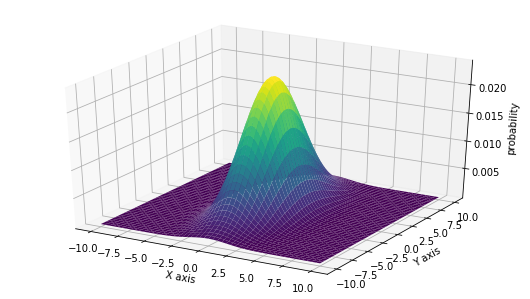

In [ ]:
######################
# --- 2D example --- #
######################

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = 0
variance_x = 3

mu_y = 0
variance_y = 15

#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('probability')
plt.show()

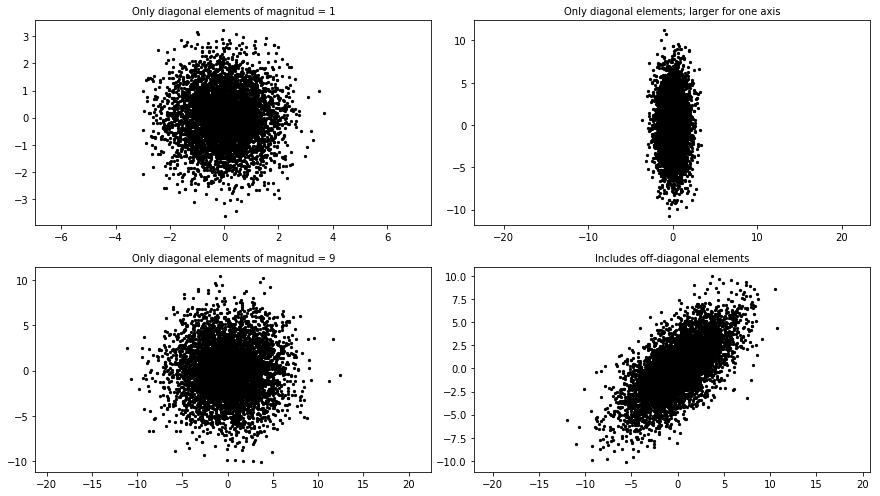

In [ ]:
mean = [0, 0]
cov_1 = [[1, 0], [0, 1]]
cov_2 = [[1, 0], [0, 9]]
cov_3 = [[9, 0], [0, 9]]
cov_4 = [[9, 6], [6, 9]]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5/1.5, 10.5/1.5)


x_, y_ = np.random.multivariate_normal(mean, cov_1, 5000).T
axs[0, 0].scatter(x_, y_, s=5, color='black')
axs[0, 0].set_title('Only diagonal elements of magnitud = 1', fontsize=10)
axs[0, 0].axis('equal')

x_, y_ = np.random.multivariate_normal(mean, cov_2, 5000).T
axs[0, 1].scatter(x_, y_, s=5, color='black')
axs[0, 1].set_title('Only diagonal elements; larger for one axis', fontsize=10)
axs[0, 1].axis('equal')

x_, y_ = np.random.multivariate_normal(mean, cov_3, 5000).T
axs[1, 0].scatter(x_, y_, s=5, color='black')
axs[1, 0].set_title('Only diagonal elements of magnitud = 9', fontsize=10)
axs[1, 0].axis('equal')

x_, y_ = np.random.multivariate_normal(mean, cov_4, 5000).T
axs[1, 1].scatter(x_, y_, s=5, color='black')
axs[1, 1].set_title('Includes off-diagonal elements', fontsize=10)
axs[1, 1].axis('equal')

fig.tight_layout()
plt.show()



### Identities for multivariate Gaussian distributions (important for GPs)

#### Joint independent normals

If $x$ and $y$ are normally distributed and *statistically independent*:

$$x\sim\mathcal{N}(\mu_x,\Sigma_x),\quad y\sim\mathcal{N}(\mu_y,\Sigma_y)$$

Their joint density is then:

$\begin{bmatrix}  x  \\  y \end{bmatrix}$
$\sim\mathcal{N}$
$\begin{pmatrix}   \begin{bmatrix}  \mu_x  \\  \mu_y \end{bmatrix},\begin{bmatrix}  \Sigma_x & 0  \\  0 & \Sigma_y \end{bmatrix}\end{pmatrix}$

#### Conditional of a joint normal

if $x$ and $y$ are jointly normally distributed:

$\begin{bmatrix}  x  \\  y \end{bmatrix}$
$\sim\mathcal{N}$
$\begin{pmatrix} \begin{bmatrix}  \mu_x  \\  \mu_y \end{bmatrix},\begin{bmatrix}  \Sigma_x & \Sigma_{xy}  \\  \Sigma_{yx} & \Sigma_y \end{bmatrix}\end{pmatrix}$

then we have that the conditional density of $x$ given $y$ is also normal:

$${\bf x}|{\bf y}=p_{x|y}(x|y)\sim\mathcal{N}(m,P)$$

where

$m=\mu_x+\Sigma_{xy}\Sigma_y^{-1}({\bf y}-\mu_y)$

$P=\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{yx}$

where ${\bf x}|{\bf y}$ denotes the probability distribution of ${\bf x}$ given that we know the value of ${\bf y}$. Therefore, $P=\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{yx}$ has lower variances (the diagonal elements of the covariance matrix) than the marginal distribution of  ${\bf x}\sim\mathcal{N}(\mu_x,\Sigma_x)$, since we are exploiting the knowledge that the value of ${\bf y}$ gives us on ${\bf x}$ .

## What is a Gaussian process regression?

GP regression aims to model an unknown function $f({\bf x})$ using noisy observations  $y$, which are related as follows:

$$y = f({\bf x})+\epsilon$$
where
$$\epsilon \sim \mathcal{N}(0,\sigma^2_n) $$

where $y\in \mathbb{R}$, ${\bf x}\in \mathbb{R}^D$ denotes an input vector ${\bf x}=[x_1,...,x_D]$ and $\epsilon$ is Gaussian distributed measurement noise with a variance of $\sigma^2_n$





### Prediction

Assume we want to make a prediction of $f({\bf x})$ at some arbitrary input ${\bf x}$ (assuming we do not have a measurement at this point, otherwise we could simply use our measurement as the prediction). Since this prediction $f({\bf x})$ will naturaly have some associated uncertainty, GPs give a prediction of the mean value $\mu$ and a variance $\sigma^2$. Intuitively, we are assuming the function value at ${\bf x}$ to have a typical value of $\mu$, which can be expected to lie with a probability of 99.7% in between $[\mu-3\sigma,~\mu+3\sigma]$. 

In the same way as a Gaussian distribution is fully determined by a mean and standard deviation (or mean and covariance matrix in the multidimensional case). A Gaussian process is fully determined by a *mean function* and a *covariance function*.

**Mean**

The mean $\mu$ of $f({\bf x})$ in the most general case may be given by an arbitrary function, which we will denote as $m({\bf x})$, which defines the average *shape* of the function. We will later see what form $m({\bf x})$ takes, which will depend on our choise of the covariance.

**Covariance**

For the covariance function (generalization of the variance $\sigma^2$) we consider two arbitrary input vectors ${\bf x}_i$ and ${\bf x}_j$, which again have not been sampled and consequently the values of the function at these points are uncertain. If we assume the unknown function, which we wish to model, is continuous, then the function values $f({\bf x}_i)$ and $f({\bf x}_j)$ will be close if the distance between ${\bf x}_i$ and ${\bf x}_j$ is small. This can be modeled statistically by assuming that the random variables $f({\bf x}_i)$ and $f({\bf x}_j)$ are strongly correlated if the distance $||{\bf x}_i-{\bf x}_j||$ is small. Let us remember that *correlation* means that $f({\bf x}_i)$ will tend to be large if $f({\bf x}_j)$ is large, as long as ${\bf x}_i$ and ${\bf x}_j$ are close together. On the other hand if ${\bf x}_i$ and ${\bf x}_j$ are far apart, then the values of $f({\bf x}_i)$ and $f({\bf x}_j)$ are virtually independent. Therefore, we can only define the covariance if we have two or more samples. A covariance matrix defines the covariance between each two samples, and the variance in the diagonal. Hence we denote the covariance between two input vectors ${\bf x}_i$ and ${\bf x}_j$ as $k({\bf x}_i,{\bf x}_j)$ and given a set of $n$ points we denote the covariance matrix ${\bf \Sigma}$ as:

$${\bf \Sigma} = \begin{bmatrix}
    k({\bf x}_1,{\bf x}_1), & ...  & k({\bf x}_1,{\bf x}_n)  \\
    k({\bf x}_2,{\bf x}_1), & ...  &k({\bf x}_2,{\bf x}_n) \\
    \vdots & \ddots  & \vdots  \\
    k({\bf x}_n,{\bf x}_1),& ... & k({\bf x}_n,{\bf x}_n) 
\end{bmatrix}\qquad$$ 

Therefore, to definite a covariance matrix ${\bf \Sigma}$ we must define a function $k(\cdot ,\cdot )$ such that ${\bf \Sigma}$ must be a positive semidefinite matrix. There are many functions that produce a covariance matrix with this requirement, the one we have chosen to use here is the *squared-exponential covariance function*.



### Covariance matrix

### Squared-exponential covariance function

**One dimension**:

Each two samples have the following covariance:
$$k(x_i,x_j)=Cov(x_i,x_j)=\sigma_f^2~\textrm{exp} \left(-\frac{1}{2\lambda_d^2}(x_i-x_j)^2 \right)$$

Notice, as we mentioned, $k(x_i,x_j)$ will be larger, the closer $x_i$ and $x_j$ are.

$$\Sigma_{ij} = Cov(x_i,x_j)  $$

${\bf \Sigma}$ is the full covariance matrix, then:

$$K ={\bf \Sigma} + \sigma_n^2I  $$

where: 

*   $n$ is number of data points
*   ${\bf \Sigma} \in \mathbb{R}^{n \times n}$
*   $\sigma_f^2$ is the variance of the (noise free) signal: $i.e.~Cov(x_i,x_i)$
*   $\sigma_n^2$ is the variance of the measurement noise
*   $l$ is characteristic length-scale 
*   $I$ is $n \times n$ identity matrix 

**Multi-dimension**:

for vector ${\bf x}_i,~{\bf x}_j \in \mathbb{R}^{D}$ we have:

$$Cov({\bf x}_i,{\bf x}_j) =\sigma_f^2~\textrm{exp} \left(-\frac{1}{2}({\bf x}_i-{\bf x}_j)^T W({\bf x}_i-{\bf x}_j) \right)$$

$$\Sigma_{ij} = Cov({\bf x}_i,{\bf x}_j)  $$

${\bf \Sigma}$ is the full covariance matrix, then:

$$K ={\bf \Sigma} + \sigma_n^2I  $$

*  $\sigma_f^2 \in \mathbb{R}$
*  $W= \textrm{diag}[w_1,...,w_{D}] $, where $w_d = 1/\lambda_d^2$
*   $I$ is $n \times n$ identity matrix 
*  ${\bf \Sigma} \in \mathbb{R}^{n \times n}$

**Remarks**
*   Notice ${\bf \Sigma} \in \mathbb{R}^{n \times n}$ both in the 1D and in the multi-dimensional case
*   Intuition: function variables close in input space (${\bf x}$) are highly correlated, whilst those far away are uncorrelated
*  $w_d$, $\sigma_f^2$ are hyperparameters, aside from their physical interpretation, they have other mathematical interpretetaions. 
*  $w_d$: lengthscale, how much does the distance affect in each dimension  
*  $\sigma_f^2$: amplitude, magnitud when the points are the same (maximum maginitud), hence the systems "natural" variance.
*  This covariance is called *Second order stationary* beause first and second order moments (mean, variance and covariances) are constant throughout time and, hence, do not depend on the time at which the process is observed. As in $Cov(x_t,x_{t-k})=Cov(x_{t+h},x_{t+h-k})$ for all $t$. Notice that our covariance matrix depends only on the difference between $x_i - x_j$ irrespective of their specific position.

### Inference (how to predict new measurements?)

Given our training data:

$
X =
\begin{bmatrix}
    x_{1,1}, & ...  & x_{1,D}  \\
    x_{2,1}, & ...  &x_{2,D} \\
    \vdots & \ddots  & \vdots  \\
    x_{n,1},& ... & x_{n,D} 
\end{bmatrix}\qquad$ 
and 
$\qquad Y =
\begin{bmatrix}
    y_{1}\\
    y_{2}\\
    \vdots \\
    y_{n} 
\end{bmatrix}$

where ${\bf x}_k=[x_{k,1},...,x_{k,D}]^T$, and $X=[{\bf x}_1,...,{\bf x}_n]^T$ are our inputs and $Y$ our outputs.

We can first form our covariance matrix:
$${\bf \Sigma} = \begin{bmatrix}
    k({\bf x}_1,{\bf x}_1), & ...  & k({\bf x}_1,{\bf x}_n)  \\
    k({\bf x}_2,{\bf x}_1), & ...  &k({\bf x}_2,{\bf x}_n) \\
    \vdots & \ddots  & \vdots  \\
    k({\bf x}_n,{\bf x}_1),& ... & k({\bf x}_n,{\bf x}_n) 
\end{bmatrix}\qquad$$ 

Adding the noise term $K ={\bf \Sigma} + \sigma_n^2I  $

From the above we remember the Conditional of a joint normal

#### Conditional of a joint normal

if $x$ and $y$ are jointly normally distributed:

$\begin{bmatrix}  x  \\  y \end{bmatrix}$
$\sim\mathcal{N}$
$\begin{pmatrix} \begin{bmatrix}  \mu_x  \\  \mu_y \end{bmatrix},\begin{bmatrix}  \Sigma_x & \Sigma_{xy}  \\  \Sigma_{yx} & \Sigma_y \end{bmatrix}\end{pmatrix}$

then we have that the conditional density of $x$ given $y$ is also normal:

$${\bf x}|{\bf y}=p_{x|y}(x|y)\sim\mathcal{N}(m,P)$$

where

$m=\mu_x+\Sigma_{xy}\Sigma_y^{-1}({\bf y}-\mu_y)$

$P=\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{yx}$

#### Conditional of a Gaussian process on data ${\bf X},{\bf Y},{\bf x}_{new}$

We know that $cov(y_i,y_j)=k(x_i,x_j)+\sigma^2_n \delta_{ij}$ and so that $cov({\bf Y})={\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I$, where ${\bf K} = {\bf \Sigma} + \sigma_n^2I$. Furthermore, we can choose our mean function $m({\bf x})=0$. Hence, when a new observation ${\bf x}_{new}$ takes place our prediction ${\bf y}_{new}$ will be conditioned on our observed (trainning) data:

$\begin{bmatrix}  {\bf Y}  \\  y_{new} \end{bmatrix}$
$\sim\mathcal{N}$
$\begin{pmatrix} \begin{bmatrix}  {\bf 0}  \\  0 \end{bmatrix},\begin{bmatrix}  {\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I & {\bf \Sigma}({\bf X},{\bf x}_{new})  \\  {\bf \Sigma}({\bf x}_{new},{\bf X}) & {\bf \Sigma}({\bf x}_{new},{\bf x}_{new}) \end{bmatrix}\end{pmatrix}$

where ${\bf \Sigma}({\bf X},{\bf x_{new}})=[Cov({\bf x}_1,{\bf x}_{new}),...,Cov({\bf x}_n,{\bf x}_{new})]^T$

Then, for a new observation 

$$y_{new}|{\bf X},{\bf Y},{\bf x}_{new}\sim\mathcal{N}(\mu_{y_{new}},\sigma^2_{y_{new}})$$

$$\mu_{y_{new}}=\mathbb{E}[y_{new}|{\bf X},{\bf Y},{\bf x}_{new}]={\bf \Sigma}({\bf x}_{new},{\bf X})[{\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I]^{-1}{\bf Y}$$


$$\sigma_{y_{new}}={\bf \Sigma}({\bf x}_{new},{\bf x}_{new})-{\bf \Sigma}({\bf x}_{new},{\bf X})[{\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I]^{-1}{\bf \Sigma}({\bf X},{\bf x}_{new})$$


## Determine hyperparameters

The first step is to determine ${\bf \Theta}=\{w_1,...,w_{D}, \sigma_f^2, \sigma_n^2  \}$ which you can define from experience, or knowledge from the system/function under study. Or you could estimate them based on $X$ and $Y$. In the below section "*Hyperparameter training*" we describe how to estimate these from data $X$ and $Y$ using **Maximum Likelihood estimation**. For now let's assume we have determined all values of ${\bf \Theta}=\{w_1,...,w_{D}, \sigma_f^2, \sigma_n^2  \}$.

After you determined  ${\bf \Theta}$ you have a working Gaussian process, such that given a new value ${\bf x}_{n+1}=[x_{n+1,1},...,x_{n+1,D}]^T$ you can get a prediction $y_{n+1}$.



### Hyperparameter training

Given a training dataset with inputs $X$ and observations $Y$ we wish to find the best hyperparameters that describe our Gaussian process ${\bf \Theta}=\{w_1,...,w_{D}, \sigma_f^2, \sigma_n^2  \}$. For this, we wish to maximize the likelohood of our parameters given our data. In simple terms, which hyperparameters can be used to better describe the data we are observing $(X,Y)$.


### Negative log-likelihood

We know that ${\bf Y| X} \sim \mathcal{N}({\bf 0,K})$, therefore we have the probability density function (PDF)

$$p({\bf Y| X})=\frac{1}{(2\pi)^{n/2}(\text{det}[{\bf K}])^{1/2}}\text{exp}\left[-\frac{1}{2}{\bf Y}^T{\bf K}^{-1}{\bf Y}\right]$$

then by taking the log:

$$\textrm{log}[p({\bf Y| X})]=-\frac{n}{2}\textrm{log}(2\pi)-\frac{1}{2}\textrm{log}(\textrm{det}|{\bf K}|)-\frac{1}{2}{\bf Y}^T{\bf K}^{-1}{\bf Y}$$

Let us denote ${\bf \Theta}=\{w_1,...,w_{D}, \sigma_f^2, \sigma_n^2  \}$ (which are not explicitely written here, but are contained in ${\bf K}$). Hence we have:

$$\mathcal{L}({\bf \Theta})=-\textrm{log}[p({\bf Y| X})]=\frac{n}{2}\textrm{log}(2\pi)+\frac{1}{2}\textrm{log}(\textrm{det}|{\bf K}|)+\frac{1}{2}{\bf Y}^T{\bf K}^{-1}{\bf Y}$$

We wish to maximize the log-likelihood, hence, we can minimize the negative log-likelihood and therefore by using nonlinear optimization algorithms we can obtain the optimal hyperparameters:

$${\bf \Theta}^* \in \textrm{argmin}_{\bf \Theta}~\mathcal{L}({\bf \Theta})$$

## Gaussian Process summary

If we assume a Gaussian process describes our function $f({\bf x})$ , then:

$$f({\bf x}) \sim \mathcal{GP}(m({\bf x}), k({\bf x},{\bf x}'))$$

The noisy observations $y$ also follow a GP due to the additive property of Gaussian distributions with the same mean, but with a different covariance function to account for the measurement noise:

$$y = f({\bf x})+\sigma_n^2$$

$$y \sim \mathcal{GP}(m({\bf x}), k({\bf x},{\bf x}')+\sigma_n^2\delta({\bf x},{\bf x}'))$$

where $\delta({\bf x},{\bf x}')=1$ *iff* ${\bf x}={\bf x}'$ and else $\delta({\bf x},{\bf x}')=0$ , known as the Kronecker-delta. This means that the measurement noise term is only aplicable to the variance (since if you measure the same point twice you might get stlightly different results due to this measurement error).

Given training data ${\bf X}$ and ${\bf Y}$ a hyperparameter optimization can be conducted, such that the most likely hyperparameters that describe the data ${\bf \Theta}=\{w_1,...,w_{D}, \sigma_f^2, \sigma_n^2  \}$ can be determined.

Once hyperparameters have been determined, and conditioning on the training data, the Gaussian process can make inference on new data by the following equations

$$y_{new}|{\bf X},{\bf Y},{\bf x}_{new}\sim\mathcal{N}(\mu_{y_{new}},\sigma^2_{y_{new}})$$

$$\mu_{y_{new}}=\mathbb{E}[y_{new}|{\bf X},{\bf Y},{\bf x}_{new}]={\bf \Sigma}({\bf x}_{new},{\bf X})[{\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I]^{-1}{\bf Y}$$


$$\sigma_{y_{new}}={\bf \Sigma}({\bf x}_{new},{\bf x}_{new})-{\bf \Sigma}({\bf x}_{new},{\bf X})[{\bf \Sigma}({\bf X},{\bf X}) + \sigma_n^2I]^{-1}{\bf \Sigma}({\bf X},{\bf x}_{new})$$

## Other technical details


### Getting around the matrix inversion

For computational reasons it is not desiable to invert the matrix $K$ as shown in the log-likelihood calculation above. 

### Cholesky decomposition

Cholesky decomposition can be used on square matrices which are positive-definite and whose transpose is the same as the original. This decomposes the original matrix into the product of a lower triangular matrix and its transpose, which is useful for efficient numerical solutions.

$$A = LL^T$$

where $L$ is a lower triangular matrix with positive diagonal entries. Every real-valued symmetric positive-definite matrix has a unique Cholesky decomposition. The computational complexity is $\mathcal{O}(n^3)$ in general, so it is advantageos in a framework that inverts matrices when it is done once, but used multiple times, as well as for numerical stability.

Note: Cholesky decomposition has a broader definition with complex matrices, but we will keep it simple for now.

### Inverting the $K$ matrix

$K = \frac{1}{2}(K+K^T)\qquad~$ *ensures it is symmetric positive-definite*

$L = \text{cholesky}(K) \qquad~$ *obtains cholesky decomposition of K*

$Lx=Y$: $\qquad\qquad\qquad$ *solves* $x=L^{-1}Y$ 

$L^T\alpha=x$$\qquad\qquad\qquad$ *solves* $\alpha=(L^T)^{-1}L^{-1}Y$

We will see that in many cases (such as the hyperparameter estimation above) , we wish to use $K^{-1}Y$, which we have just computed above as $\alpha=(L^T)^{-1}L^{-1}Y$. The outline above can not only lead to computational gains if the process is donde repetitively, but is also more robust and less prone to numerical errors.

## GP in Python

In [ ]:
class GP_model:
    
    ###########################
    # --- initializing GP --- #
    ###########################    
    def __init__(self, X, Y, kernel, multi_hyper, var_out=True):
        
        # GP variable definitions
        self.X, self.Y, self.kernel = X, Y, kernel
        self.n_point, self.nx_dim   = X.shape[0], X.shape[1]
        self.ny_dim                 = Y.shape[1]
        self.multi_hyper            = multi_hyper
        self.var_out                = var_out
        
        # normalize data
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std
        
        # determine hyperparameters
        self.hypopt, self.invKopt   = self.determine_hyperparameters()        
    
    #############################
    # --- Covariance Matrix --- #
    #############################    
    
    def Cov_mat(self, kernel, X_norm, W, sf2):
        '''
        Calculates the covariance matrix of a dataset Xnorm
        --- decription ---
        '''
    
        if kernel == 'RBF':
            dist       = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*dist)
            return cov_matrix
            # Note: cdist =>  sqrt(sum(u_i-v_i)^2/V[x_i])
        else:
            print('ERROR no kernel with name ', kernel)

    ################################
    # --- Covariance of sample --- #
    ################################    
        
    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        '''
        Calculates the covariance of a single sample xnorm against the dataset Xnorm
        --- decription ---
        '''    
        # internal parameters
        nx_dim = self.nx_dim

        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)

        return cov_matrix                
        
    ###################################
    # --- negative log likelihood --- #
    ###################################   
    
    def negative_loglikelihood(self, hyper, X, Y):
        '''
        --- decription ---
        ''' 
        # internal parameters
        n_point, nx_dim = self.n_point, self.nx_dim
        kernel          = self.kernel
        
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        K       = self.Cov_mat(kernel, X, W, sf2)  # (nxn) covariance matrix (noise free)
        K       = K + (sn2 + 1e-8)*np.eye(n_point) # (nxn) covariance matrix
        K       = (K + K.T)*0.5                    # ensure K is simetric
        L       = np.linalg.cholesky(K)            # do a cholesky decomposition
        logdetK = 2 * np.sum(np.log(np.diag(L)))   # calculate the log of the determinant of K the 2* is due to the fact that L^2 = K
        invLY   = np.linalg.solve(L,Y)             # obtain L^{-1}*Y
        alpha   = np.linalg.solve(L.T,invLY)       # obtain (L.T L)^{-1}*Y = K^{-1}*Y
        NLL     = np.dot(Y.T,alpha) + logdetK      # construct the NLL

        return NLL
    
    ############################################################
    # --- Minimizing the NLL (hyperparameter optimization) --- #
    ############################################################   
    
    def determine_hyperparameters(self):
        '''
        --- decription ---
        Notice we construct one GP for each output
        '''   
        # internal parameters
        X_norm, Y_norm  = self.X_norm, self.Y_norm
        nx_dim, n_point = self.nx_dim, self.n_point
        kernel, ny_dim  = self.kernel, self.ny_dim
        Cov_mat         = self.Cov_mat
        
        
        lb               = np.array([-4.]*(nx_dim+1) + [-8.])  # lb on parameters (this is inside the exponential)
        ub               = np.array([4.]*(nx_dim+1) + [ -2.])  # ub on parameters (this is inside the exponential)
        bounds           = np.hstack((lb.reshape(nx_dim+2,1),
                                      ub.reshape(nx_dim+2,1)))
        multi_start      = self.multi_hyper                   # multistart on hyperparameter optimization
        multi_startvec   = sobol_seq.i4_sobol_generate(nx_dim + 2,multi_start)

        options  = {'disp':False,'maxiter':10000}          # solver options
        hypopt   = np.zeros((nx_dim+2, ny_dim))            # hyperparams w's + sf2+ sn2 (one for each GP i.e. output var)
        localsol = [0.]*multi_start                        # values for multistart
        localval = np.zeros((multi_start))                 # variables for multistart

        invKopt = []
        # --- loop over outputs (GPs) --- #
        for i in range(ny_dim):    
            # --- multistart loop --- # 
            for j in range(multi_start):
                print('multi_start hyper parameter optimization iteration = ',j,'  input = ',i)
                hyp_init    = lb + (ub-lb)*multi_startvec[j,:]
                # --- hyper-parameter optimization --- #
                res = minimize(self.negative_loglikelihood,hyp_init,args=(X_norm,Y_norm[:,i])\
                               ,method='SLSQP',options=options,bounds=bounds,tol=1e-12)
                localsol[j] = res.x
                localval[j] = res.fun

            # --- choosing best solution --- #
            minindex    = np.argmin(localval)
            hypopt[:,i] = localsol[minindex]
            ellopt      = np.exp(2.*hypopt[:nx_dim,i])
            sf2opt      = np.exp(2.*hypopt[nx_dim,i])
            sn2opt      = np.exp(2.*hypopt[nx_dim+1,i]) + 1e-8

            # --- constructing optimal K --- #
            Kopt        = Cov_mat(kernel, X_norm, ellopt, sf2opt) + sn2opt*np.eye(n_point)
            # --- inverting K --- #
            invKopt     += [np.linalg.solve(Kopt,np.eye(n_point))]

        return hypopt, invKopt

    ########################
    # --- GP inference --- #
    ########################     
    
    def GP_inference_np(self, x):
        '''
        --- decription ---
        '''
        nx_dim                   = self.nx_dim
        kernel, ny_dim           = self.kernel, self.ny_dim
        hypopt, Cov_mat          = self.hypopt, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.invKopt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        var_out                  = self.var_out
        # Sigma_w                = self.Sigma_w (if input noise)

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        # --- Loop over each output (GP) --- #
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # --- determine covariance of each output --- #
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error
            #var[i] = sf2opt + Sigma_w[i,i]/stdY[i]**2 - np.matmul(np.matmul(k.T,invK),k) (if input noise)

        # --- compute un-normalized mean --- #    
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        if var_out:
            return mean_sample, var_sample
        else:
            return mean_sample.flatten()[0]

           

## Examples

### 1D input 1D output example

$
X =
\begin{bmatrix}
    -4\\
    -1\\
     1\\
     2 
\end{bmatrix}\qquad$ 
and 
$\qquad Y =
\begin{bmatrix}
    \text{sin}(-4)+\epsilon\\
    \text{sin}(-1)+\epsilon\\
     \text{sin}(1)+\epsilon\\
     \text{sin}(2)+\epsilon
\end{bmatrix}$

where $f(x):=\text{sin}(x)$, and $\epsilon \sim \mathcal{N}(0,10^{-3})$

In [ ]:
# --- define training data --- #
Xtrain = np.array([-4, -1, 1, 2])
ndata  = Xtrain.shape[0]
Xtrain = Xtrain.reshape(ndata,1)
fx     = np.sin(Xtrain)
eps    = np.random.normal(0, 1e-3, ndata)
ytrain = fx + eps.reshape(ndata,1)

# --- build a GP model --- #
GP_m = GP_model(Xtrain, ytrain, 'RBF', multi_hyper=3, var_out=True)

multi_start hyper parameter optimization iteration =  0   input =  0
multi_start hyper parameter optimization iteration =  1   input =  0
multi_start hyper parameter optimization iteration =  2   input =  0


In [ ]:
# --- define test data --- #
n_test      = 30
Xtest       = np.linspace(-5.0, 4.0, num=n_test)
fx_test     = np.sin(Xtest)
Ytest_mean  = np.zeros(n_test)
Ytest_std   = np.zeros(n_test)

# --- use GP to predict test data --- #
for ii in range(n_test):
    m_ii, std_ii   = GP_m.GP_inference_np(Xtest[ii])
    Ytest_mean[ii] = m_ii 
    Ytest_std[ii]  = std_ii

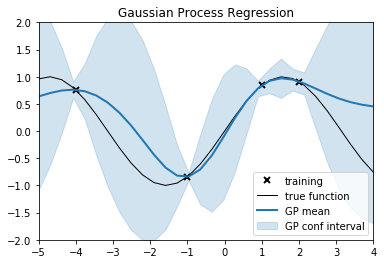

In [ ]:
# --- Plotting --- #

# plot observed points
plt.plot(Xtrain, ytrain, 'kx', mew=2)

# plot the samples of posteriors
plt.plot(Xtest, fx_test, 'black', linewidth=1)

# plot GP confidence intervals
plt.gca().fill_between(Xtest.flat, 
                       Ytest_mean - 3*np.sqrt(Ytest_std), 
                       Ytest_mean + 3*np.sqrt(Ytest_std), 
                       color='C0', alpha=0.2)

# plot GP mean
plt.plot(Xtest, Ytest_mean, 'C0', lw=2)

plt.axis([-5, 4, -2, 2])
plt.title('Gaussian Process Regression')
plt.legend(('training', 'true function', 'GP mean', 'GP conf interval'),
           loc='lower right')
plt.show()

### 2D input 1D output example

$
X =
\begin{bmatrix}
    x^1_1 & x^1_2 \\
    x^2_1 & x^2_2\\
     \vdots\\
    x^n_1 & x^n_2 
\end{bmatrix}\qquad$ 
and 
$\qquad Y =
\begin{bmatrix}
    \text{sin}(x^1_1 + x^1_2)+\epsilon\\
    \text{sin}(x^2_1 + x^2_2)+\epsilon\\
    \vdots\\\\
    \text{sin}(x^n_1 + x^n_2)+\epsilon
\end{bmatrix}$

where $f({\bf x}):=\text{sin}(x^1+x^2)$, and $\epsilon \sim \mathcal{N}(0,10^{-3})$

In [ ]:
# --- define training data --- #
x1loc  = [-4, -3, -2, -1, 0, 1, 2, 3]; x2loc = [-4, -3, -2, -1, 0, 1, 2, 3]
x1loc  = [-4, -1, 0, 2, 3]; x2loc = [-4, -1, 0, 2, 3]
Xtrain = [[x,y] for x in x1loc for y in x2loc]
Xtrain = np.array(Xtrain)

ndata  = Xtrain.shape[0]
fx     = np.sin(np.sum(Xtrain, axis=1))
eps    = np.random.normal(0, 1e-3, ndata)
ytrain = fx + eps.reshape(fx.shape, order='F')
ytrain = ytrain.reshape(ytrain.shape[0],1)

# --- build a GP model --- #
GP_m = GP_model(Xtrain, ytrain, 'RBF', multi_hyper=3, var_out=True)

multi_start hyper parameter optimization iteration =  0   input =  0
multi_start hyper parameter optimization iteration =  1   input =  0
multi_start hyper parameter optimization iteration =  2   input =  0


In [ ]:
# --- create test data --- #
n_test = 30
xtest  = [-4 + 7*(i)/(n_test-1) for i in range(n_test)]
Xtest = [[x,y] for x in xtest for y in xtest]
Xtest = np.array(Xtest)

# --- compute f(X) --- #
n_tot       = n_test * n_test
fx_test     = np.sin(np.sum(Xtest, axis=1))
Ytest_mean  = np.zeros(n_tot)
Ytest_std   = np.zeros(n_tot)

# --- use GP to predict test data --- #
for ii in range(n_tot):
    m_ii, std_ii   = GP_m.GP_inference_np(Xtest[ii,:])
    Ytest_mean[ii] = m_ii 
    Ytest_std[ii]  = std_ii

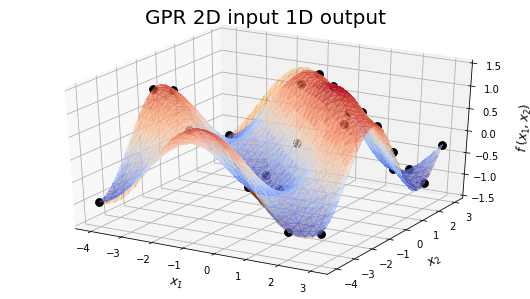

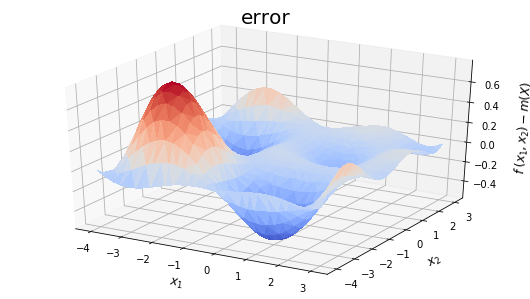

In [ ]:
# --- Plotting --- #
# importing libraries
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# setting up plot
plt = matplotlib.pyplot
fig = plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
ax = fig.add_subplot(111, projection='3d')

# labels and titles
plt.title('GPR 2D input 1D output', fontsize=20)
ax.set_xlabel(r'$\mathit{x_1}$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$\mathit{x_2}$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$\mathit{f\;(x_1,x_2)}$', fontsize=12, labelpad=10)
ax.set_zlim(-1.5, 1.5)

# Plot scattered training points
ax.scatter3D(Xtrain[:,0], Xtrain[:,1], ytrain, c='k', s=60, depthshade=False)

# plot GP mean
ax.plot_trisurf(Xtest[:,0], Xtest[:,1], Ytest_mean, cmap=cm.coolwarm, 
                linewidth=0, antialiased=False, alpha=0.5)
# plot real function
ax.plot_trisurf(Xtest[:,0], Xtest[:,1], fx_test, 
                linewidth=0, antialiased=False, alpha=0.2)

plt.show()

# setting up plot
plt = matplotlib.pyplot
fig = plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
ax = fig.add_subplot(111, projection='3d')

# labels and titles
plt.title('error', fontsize=20)
ax.set_xlabel(r'$\mathit{x_1}$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$\mathit{x_2}$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$\mathit{f\;(x_1,x_2)-m(X)}$', fontsize=12, labelpad=10)

# plot diffenrece between function and GP mean
ax.plot_trisurf(Xtest[:,0], Xtest[:,1], fx_test-Ytest_mean, cmap=cm.coolwarm, 
                linewidth=0, antialiased=False, alpha=1)

plt.show()

### 2D input 3D output example

$
X =
\begin{bmatrix}
    x^1_1 & x^1_2 \\
    x^2_1 & x^2_2\\
     \vdots\\
    x^n_1 & x^n_2 
\end{bmatrix}\qquad$ 
and 
$\qquad Y =
\begin{bmatrix}
    \text{sin}(x^1_1 + x^1_2)&(x^1_1 + x^1_2)^2&\text{sin}(x^1_1 + x^1_2)+\frac{1}{50}(x^1_1 + x^1_2)\\
    \text{sin}(x^2_1 + x^2_2)&(x^2_1 + x^2_2)^2&\text{sin}(x^2_1 + x^2_2)+\frac{1}{50}(x^2_1 + x^2_2)^2\\
    \vdots&\vdots&\vdots\\\\
    \text{sin}(x^n_1 + x^n_2)&(x^n_1 + x^n_2)^2&\text{sin}(x^n_1 + x^n_2)+\frac{1}{50}(x^n_1 + x^n_2)^2
\end{bmatrix}+\epsilon$

where 
$$f_1({\bf x}):=\text{sin}(x^1+x^2)$$
$$f_2({\bf x}):=(x^1+x^2)^2$$
$$f_3({\bf x}):=\text{sin}(x^1+x^2)+\frac{1}{50}(x^1+x^2)^2$$

$\epsilon \sim \mathcal{N}(0,10^{-3})$

In [ ]:
# --- define training data --- #
x1loc  = [-4, -3, -2, -1, 0, 1, 2, 3]; x2loc = [-4, -3, -2, -1, 0, 1, 2, 3]
x1loc  = [-4, -1, 0, 2, 3]; x2loc = [-4, -1, 0, 2, 3]
Xtrain = [[x,y] for x in x1loc for y in x2loc]
Xtrain = np.array(Xtrain)

ndata   = Xtrain.shape[0]
# f(x) functions
fx1     = np.sin(np.sum(Xtrain, axis=1))
fx2     = np.square(np.sum(Xtrain, axis=1))/50.
fx3     = fx1 + fx2
eps     = np.random.normal(0, 1e-3, ndata)
# f(x) + eps
ytrain1 = fx1 + eps.reshape(fx1.shape); ytrain1  = ytrain1.reshape(ytrain1.shape[0],1)
ytrain2 = fx2 + eps.reshape(fx2.shape); ytrain2  = ytrain2.reshape(ytrain2.shape[0],1)
ytrain3 = fx3 + eps.reshape(fx3.shape); ytrain3  = ytrain3.reshape(ytrain3.shape[0],1)

ytrain  = np.hstack((ytrain1, ytrain2, ytrain3))
print(ytrain.shape)

# --- build a GP model --- #
GP_m = GP_model(Xtrain, ytrain, 'RBF', multi_hyper=3, var_out=True)

(25, 3)
multi_start hyper parameter optimization iteration =  0   input =  0
multi_start hyper parameter optimization iteration =  1   input =  0
multi_start hyper parameter optimization iteration =  2   input =  0
multi_start hyper parameter optimization iteration =  0   input =  1
multi_start hyper parameter optimization iteration =  1   input =  1
multi_start hyper parameter optimization iteration =  2   input =  1
multi_start hyper parameter optimization iteration =  0   input =  2
multi_start hyper parameter optimization iteration =  1   input =  2
multi_start hyper parameter optimization iteration =  2   input =  2


In [ ]:
# --- create test data --- #
n_test = 30
xtest  = [-4 + 7*(i)/(n_test-1) for i in range(n_test)]
Xtest = [[x,y] for x in xtest for y in xtest]
Xtest = np.array(Xtest)

# --- compute f(X) --- #
n_tot    = n_test * n_test
fx_test1 = np.sin(np.sum(Xtest, axis=1))
fx_test2 = np.square(np.sum(Xtest, axis=1))/50.
fx_test3 = fx_test1 + fx_test2
fx_test  = np.vstack((fx_test1, fx_test2, fx_test3))

Ytest_mean   = np.zeros((n_tot,3))
Ytest_std    = np.zeros((n_tot,3))

# --- use GP to predict test data --- #
for ii in range(n_tot):
    m_ii, std_ii     = GP_m.GP_inference_np(Xtest[ii,:])
    Ytest_mean[ii,:] = m_ii 
    Ytest_std[ii,:]  = std_ii

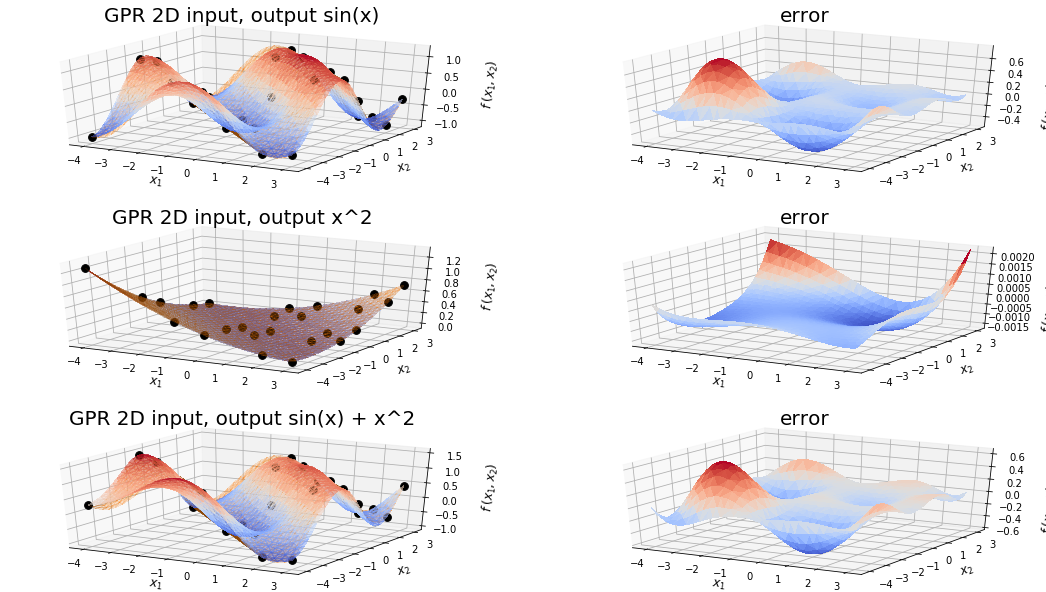

In [ ]:
# --- Plotting --- #
# importing libraries
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ttl = ['sin(x)','x^2','sin(x) + x^2']

for ij in range(3):
    # setting up plot
    ax = fig.add_subplot(3, 2, ij*2+1, projection='3d')

    # labels and titles
    ax.set_title('GPR 2D input, output '+str(ttl[ij]), fontsize=20)
    ax.set_xlabel(r'$\mathit{x_1}$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$\mathit{x_2}$', fontsize=12, labelpad=10)
    ax.set_zlabel(r'$\mathit{f\;(x_1,x_2)}$', fontsize=12, labelpad=10)

    # Plot scattered training points
    ax.scatter3D(Xtrain[:,0], Xtrain[:,1], ytrain[:,ij], c='k', s=60, depthshade=False)

    # plot GP mean
    ax.plot_trisurf(Xtest[:,0], Xtest[:,1], Ytest_mean[:,ij], cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False, alpha=0.5)
    # plot real function
    ax.plot_trisurf(Xtest[:,0], Xtest[:,1], fx_test[ij,:], 
                    linewidth=0, antialiased=False, alpha=0.2)

    # set uo plot 
    ax = fig.add_subplot(3, 2, (ij*2+2), projection='3d')
    # labels and titles
    ax.set_title('error', fontsize=20)
    ax.set_xlabel(r'$\mathit{x_1}$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$\mathit{x_2}$', fontsize=12, labelpad=10)
    ax.set_zlabel(r'$\mathit{f\;(x_1,x_2)-m(X)}$', fontsize=12, labelpad=10)

    # plot diffenrece between function and GP mean
    ax.plot_trisurf(Xtest[:,0], Xtest[:,1], fx_test[ij,:]-Ytest_mean[:,ij], cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False, alpha=1)

plt.show()

##References

*   [1] E. Bradford, A. M. Schweidtmann, D. Zhang, K. Jing, E. A. del Rio-Chanona, Dynamic modeling and optimization of sustainable algal production with uncertainty using multivariate Gaussian processes, Comp. Chem. Eng., 118, 143-158, 2018
*   [2] Gaussian Processes for Machine Learning, C.E. Rasmussen and C.K.I. Williams, The MIT Press, 2006. ISBN 0-262-18253-X.




